# Reconstructing the South Pacific Nuclear Free Zone

[The Treaty of Tlatelolco](https://opanal.org/en/zone-of-application/) contains this description of the application zone (Article 4):

> Upon fulfillment of the requirements of Article 29, paragraph 1, the Zone of Application of this Treaty shall also be that which is situated in the western hemisphere within the following limits (except the continental part of the territory of the United States of America and its territorial waters): starting at a point located at 35º north latitude, 75º west longitude; from this point directly southward to a point at 30º north latitude, 75º west longitude; from there, directly eastward to a point at 30º north latitude, 50º west longitude; from there, along a loxodromic line to a point at 5º north latitude, 20º west longitude; from there, directly southward to a point at 60º south latitude, 20º west longitude; from there, directly westward to a point at 60º south latitude, 115º west longitude; from there, directly northward to a point at 0º latitude, 115º west longitude; from there, along a loxodromic line to a point at 35º north latitude, 150º west longitude; from there, directly eastward to a point at 35º north latitude, 75º west longitude.

We'll contruct this geometry by writing out the straight line segments, then subtracting the combined area of the United States its territorial waters.


In [115]:
import geopandas as gp
import shapely as shp

world_admin0 = gp.read_file("./tmp/ne_50m_admin_0_countries.geojson")
usa_12nm = gp.read_file("./tmp/usa_12nm_exterior.geojson")

In [116]:
# Source: rick debbout / https://stackoverflow.com/a/70387141
def remove_interiors(poly):
    if poly.interiors:
        return shp.geometry.Polygon(list(poly.exterior.coords))
    else:
        return poly

def pop_largest(gs):
    geoms = [g.area for g in gs]
    return gs.pop(geoms.index(max(geoms)))

def close_holes(geom):
    if isinstance(geom, shp.geometry.MultiPolygon):
        ser = gp.GeoSeries([remove_interiors(g) for g in geom.geoms])
        big = pop_largest(ser)
        outers = ser.loc[~ser.within(big)].tolist()
        if outers:
            return shp.geometry.MultiPolygon([big] + outers)
        return shp.geometry.Polygon(big)
    if isinstance(geom, shp.geometry.Polygon):
        return remove_interiors(geom)

(24.0, 35.0)

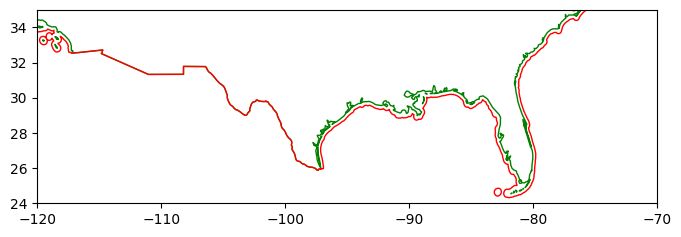

In [117]:
# Prepare United States geometry
usa_land = world_admin0.loc[world_admin0["adm0_a3"] == "USA"]
usa_geo = shp.union_all([usa_land.geometry, usa_12nm.geometry])
usa_territory = gp.GeoDataFrame(data={"geometry":[usa_geo]}, geometry="geometry")
usa_territory.geometry = usa_territory.geometry.apply(lambda x: close_holes(x))

# Plot
ax = usa_territory.plot(figsize=(8,8), color="none", edgecolor="red")
usa_land.plot(ax=ax, color="none", edgecolor="green",zorder=-10)
ax.set_xlim([-120,-70])
ax.set_ylim([24, 35])

In [118]:
# Build treaty extent geometry 
treaty_geo = shp.geometry.Polygon(
    [
    # ...starting at a point located at 35º north latitude, 75º west longitude;
    (-75,35),
    # from this point directly southward to a point at 30º north latitude, 75º west longitude;
    (-75, 30),
    # from there, directly eastward to a point at 30º north latitude, 50º west longitude;
    (-50, 30),
    # from there, along a loxodromic line to a point at 5º north latitude, 20º west longitude;
    (-20, 5),
    # from there, directly southward to a point at 60º south latitude, 20º west longitude;
    (-20, -60),
    # from there, directly westward to a point at 60º south latitude, 115º west longitude;
    (-115, -60),
    # from there, directly northward to a point at 0º latitude, 115º west longitude;
    (-115, 0),
    # from there, along a loxodromic line to a point at 35º north latitude, 150º west longitude;
    (-150, 35)
    # (omitting return to origin)
    ]
)

# ...except the continental part of the territory of the United States of America and its territorial waters
treaty_geo = shp.difference(treaty_geo, usa_territory.geometry).explode(index_parts=True)

treaty_extent = gp.GeoDataFrame(
    data={
        "geometry": [
            *list(treaty_geo),
        ]
    },
    geometry="geometry",
    crs="EPSG:4326",
)


treaty_extent.to_file("./tmp/tlatelolco-extent.geojson")

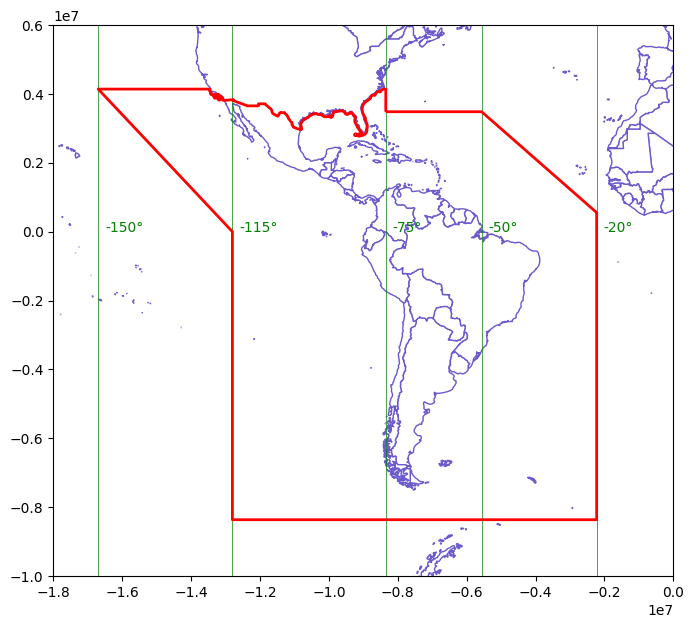

In [119]:
# Plot
proj4 = "+proj=merc"
treaty_extent_proj = treaty_extent.to_crs(crs=proj4)
countries_proj = world_admin0.to_crs(crs=proj4)

treaty_extent_proj = treaty_extent.to_crs(crs=proj4)
ax = countries_proj.plot(edgecolor="slateblue",color="white", figsize=(8,8))
treaty_extent_proj.plot(zorder=100, edgecolor="red", color="none", lw=2, ax=ax)

ax.set_xlim([-1.8e7,0e7])
ax.set_ylim([-1e7, .6e7])
long20 = shp.geometry.LineString([(-20, -90), (-20, 90)])
long75 = shp.geometry.LineString([(-75, -90), (-75, 90)])
long50 = shp.geometry.LineString([(-50, -90), (-50, 90)])
long115 = shp.geometry.LineString([(-115, -90), (-115, 90)])
long150 = shp.geometry.LineString([(-150, -90), (-150, 90)])

longs = gp.GeoDataFrame(
    data={
        "name":["-75°", "-115°", "-150°", "-20°", "-50°"],
        "geometry": [long75, long115, long150, long20, long50]},
    crs="EPSG:4326").to_crs(proj4)

longs.plot(ax=ax, lw=.5,edgecolor="green")
longs.apply(lambda x:
            ax.annotate(
                text=x['name'],
                color="green",
                xy=x.geometry.centroid.coords[0],
                xytext=(
                    x.geometry.centroid.coords[0][0] + 2e5,
                    x.geometry.centroid.coords[0][1]),
                ha='left'),
                axis=1);